In [1]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)

IN COLAB:  True


In [20]:
import os
import pandas as pd

parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')

train_df
val_df


,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...
...,...,...
635,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
636,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
637,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
638,flag_waving,<BOS> He also sang an Islamic State fight song...


In [21]:
import re
experiment = True

def extract_tagged_section(row):
    pattern = r'<BOS>.*?<EOS>'
    match = re.search(pattern, row['tagged_in_context'])
    return match.group() if match else ""

def extract_text_inside_tags(row):
    pattern = r'<BOS>(.*?)<EOS>'
    match = re.search(pattern, row['tagged_in_context'])
    return match.group(1).strip() if match else ""

def transform_multi_label(row):
    new_value = label_to_id[row['label']]
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string


if not experiment:
  label_to_id = {'flag_waving': 0, 'exaggeration,minimisation': 1, 'causal_oversimplification': 2, 'name_calling,labeling': 3, 'repetition': 4, 'doubt': 5, 'not_propaganda': 6, 'loaded_language': 7, 'appeal_to_fear_prejudice': 8}
  id_to_label = {0: 'flag_waving', 1: 'exaggeration,minimisation', 2: 'causal_oversimplification', 3: 'name_calling,labeling', 4: 'repetition', 5: 'doubt', 6: 'not_propaganda', 7: 'loaded_language', 8: 'appeal_to_fear_prejudice'}

  train_df['label_str'] = train_df.apply(transform_multi_label, axis=1)
  # train_df['original_without_snip_tags'] = train_df.apply(transform_strip_tag, axis=1)
  train_df['extract_no_tags'] = train_df.apply(extract_text_inside_tags, axis=1)
  train_df['extract_with_tags'] = train_df.apply(extract_tagged_section, axis=1)

  val_df['label_str'] = val_df.apply(transform_multi_label, axis=1)
  val_df['extract_no_tags'] = val_df.apply(extract_text_inside_tags, axis=1)
  val_df['extract_with_tags'] = val_df.apply(extract_tagged_section, axis=1)
  # val_df['original_without_snip_tags'] = val_df.apply(transform_strip_tag, axis=1)

  train_df
  val_df

if experiment:
  print('here')
  # Drop rows where 'label' is 'not_propaganda' in train_df and val_df
  train_df = train_df.drop(train_df[train_df['label'] == 'not_propaganda'].index)
  val_df = val_df.drop(val_df[val_df['label'] == 'not_propaganda'].index)

  label_to_id = {'flag_waving': 0, 'exaggeration,minimisation': 1, 'causal_oversimplification': 2, 'name_calling,labeling': 3, 'repetition': 4, 'doubt': 5, 'loaded_language': 6, 'appeal_to_fear_prejudice': 7}
  id_to_label = {0: 'flag_waving', 1: 'exaggeration,minimisation', 2: 'causal_oversimplification', 3: 'name_calling,labeling', 4: 'repetition', 5: 'doubt',6: 'loaded_language', 7: 'appeal_to_fear_prejudice'}

  train_df['label_str'] = train_df.apply(transform_multi_label, axis=1)
  # train_df['original_without_snip_tags'] = train_df.apply(transform_strip_tag, axis=1)
  train_df['extract_no_tags'] = train_df.apply(extract_text_inside_tags, axis=1)
  train_df['extract_with_tags'] = train_df.apply(extract_tagged_section, axis=1)

  val_df['label_str'] = val_df.apply(transform_multi_label, axis=1)
  val_df['extract_no_tags'] = val_df.apply(extract_text_inside_tags, axis=1)
  val_df['extract_with_tags'] = val_df.apply(extract_tagged_section, axis=1)
  # val_df['original_without_snip_tags'] = val_df.apply(transform_strip_tag, axis=1)


  val_df

here


In [22]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
import torch
import numpy as np



class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df, sent_col, target_col):
        tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

        self.labels=torch.tensor([label for label in df[target_col]])
        print(self.labels)
        self.texts=[tokenizer(text,padding='max_length',max_length=64,truncation=True,return_tensors="pt") for text in df[sent_col]]
        # print(self.texts)
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [23]:
# sent_col = 'extract_with_tags'
sent_col = 'extract_no_tags'
target_col = 'label_str'
# target_col = 'propaganda'

train_data = CustomPropagandaDataset_vanilla(train_df,sent_col, target_col)
val_data = CustomPropagandaDataset_vanilla(val_df,sent_col, target_col)

tensor([0, 6, 5,  ..., 0, 2, 3])
tensor([2, 7, 4, 3, 6, 0, 5, 6, 0, 7, 2, 3, 1, 1, 1, 3, 0, 6, 5, 5, 4, 1, 3, 1,
        5, 5, 7, 0, 5, 7, 0, 1, 7, 7, 5, 0, 1, 0, 6, 6, 6, 4, 7, 0, 6, 7, 4, 7,
        0, 7, 5, 1, 3, 4, 6, 0, 4, 5, 5, 5, 4, 3, 7, 0, 1, 2, 7, 3, 7, 6, 5, 7,
        5, 3, 7, 6, 5, 1, 5, 2, 0, 3, 4, 1, 2, 7, 2, 5, 5, 4, 7, 0, 2, 5, 6, 3,
        2, 1, 3, 7, 5, 7, 0, 0, 3, 6, 6, 6, 6, 3, 7, 5, 7, 1, 6, 2, 1, 2, 0, 1,
        5, 7, 3, 7, 3, 7, 7, 0, 7, 0, 1, 5, 4, 0, 1, 1, 4, 2, 6, 2, 5, 5, 2, 4,
        3, 4, 2, 2, 3, 4, 4, 6, 5, 6, 0, 0, 4, 0, 4, 3, 6, 4, 3, 2, 6, 3, 0, 0,
        0, 5, 4, 1, 4, 2, 3, 0, 4, 0, 2, 0, 6, 7, 6, 4, 3, 3, 5, 3, 0, 5, 3, 2,
        4, 1, 5, 5, 7, 3, 5, 6, 1, 1, 5, 2, 0, 1, 0, 0, 6, 7, 1, 4, 4, 3, 0, 1,
        5, 4, 3, 3, 1, 3, 3, 6, 4, 7, 5, 3, 2, 4, 4, 4, 5, 4, 1, 2, 7, 6, 2, 2,
        5, 0, 1, 5, 4, 0, 6, 2, 2, 2, 0, 0, 7, 7, 4, 6, 6, 4, 7, 7, 2, 5, 4, 6,
        3, 7, 4, 0, 2, 7, 6, 4, 7, 3, 2, 7, 7, 6, 1, 2, 7, 6, 4, 6, 0, 5, 0, 5,
       

In [24]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=4,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=4)

In [25]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self,dropout=0.5,num_classes=9):
        super(BertClassifier, self).__init__()

        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        _, pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [26]:
# wills
epochs = 20
lr = 5e-6
batch_size=50
max_len=150

100%|██████████| 323/323 [00:29<00:00, 10.91it/s]


Epochs: 1 | Train Loss: 0.515 | Train Accuracy: 0.170
Val loss: 0.500 | Val Accuracy: 0.246


100%|██████████| 323/323 [00:29<00:00, 10.97it/s]


Epochs: 2 | Train Loss: 0.491 | Train Accuracy: 0.231
Val loss: 0.475 | Val Accuracy: 0.265


100%|██████████| 323/323 [00:29<00:00, 10.92it/s]


Epochs: 3 | Train Loss: 0.472 | Train Accuracy: 0.249
Val loss: 0.462 | Val Accuracy: 0.275


100%|██████████| 323/323 [00:29<00:00, 10.96it/s]


Epochs: 4 | Train Loss: 0.445 | Train Accuracy: 0.314
Val loss: 0.452 | Val Accuracy: 0.246


100%|██████████| 323/323 [00:29<00:00, 10.98it/s]


Epochs: 5 | Train Loss: 0.423 | Train Accuracy: 0.352
Val loss: 0.446 | Val Accuracy: 0.256


100%|██████████| 323/323 [00:29<00:00, 10.94it/s]


Epochs: 6 | Train Loss: 0.402 | Train Accuracy: 0.410
Val loss: 0.437 | Val Accuracy: 0.301


100%|██████████| 323/323 [00:29<00:00, 10.95it/s]


Epochs: 7 | Train Loss: 0.372 | Train Accuracy: 0.457
Val loss: 0.431 | Val Accuracy: 0.320


100%|██████████| 323/323 [00:29<00:00, 10.94it/s]


Epochs: 8 | Train Loss: 0.338 | Train Accuracy: 0.554
Val loss: 0.429 | Val Accuracy: 0.311


100%|██████████| 323/323 [00:29<00:00, 10.95it/s]


Epochs: 9 | Train Loss: 0.313 | Train Accuracy: 0.607
Val loss: 0.447 | Val Accuracy: 0.317


100%|██████████| 323/323 [00:29<00:00, 10.90it/s]


Epochs: 10 | Train Loss: 0.276 | Train Accuracy: 0.633
Val loss: 0.445 | Val Accuracy: 0.337


100%|██████████| 323/323 [00:29<00:00, 10.89it/s]


Epochs: 11 | Train Loss: 0.238 | Train Accuracy: 0.722
Val loss: 0.457 | Val Accuracy: 0.337


100%|██████████| 323/323 [00:29<00:00, 10.92it/s]


Epochs: 12 | Train Loss: 0.205 | Train Accuracy: 0.779
Val loss: 0.459 | Val Accuracy: 0.359


100%|██████████| 323/323 [00:29<00:00, 10.93it/s]


Epochs: 13 | Train Loss: 0.177 | Train Accuracy: 0.818
Val loss: 0.500 | Val Accuracy: 0.356


100%|██████████| 323/323 [00:29<00:00, 10.96it/s]


Epochs: 14 | Train Loss: 0.144 | Train Accuracy: 0.858
Val loss: 0.495 | Val Accuracy: 0.366


100%|██████████| 323/323 [00:29<00:00, 10.93it/s]


Epochs: 15 | Train Loss: 0.124 | Train Accuracy: 0.881
Val loss: 0.511 | Val Accuracy: 0.353


100%|██████████| 323/323 [00:29<00:00, 10.94it/s]


Epochs: 16 | Train Loss: 0.105 | Train Accuracy: 0.901
Val loss: 0.544 | Val Accuracy: 0.333


100%|██████████| 323/323 [00:29<00:00, 10.94it/s]


Epochs: 17 | Train Loss: 0.085 | Train Accuracy: 0.931
Val loss: 0.550 | Val Accuracy: 0.362


100%|██████████| 323/323 [00:29<00:00, 10.91it/s]


Epochs: 18 | Train Loss: 0.074 | Train Accuracy: 0.943
Val loss: 0.586 | Val Accuracy: 0.353


100%|██████████| 323/323 [00:29<00:00, 10.92it/s]


Epochs: 19 | Train Loss: 0.063 | Train Accuracy: 0.941
Val loss: 0.588 | Val Accuracy: 0.359


100%|██████████| 323/323 [00:29<00:00, 10.96it/s]


Epochs: 20 | Train Loss: 0.054 | Train Accuracy: 0.954
Val loss: 0.596 | Val Accuracy: 0.369
______TEST______
LR: 5e-06 FINAL ACC = 0.369
LR: 5e-06 BEST ACC = 0.369
____________


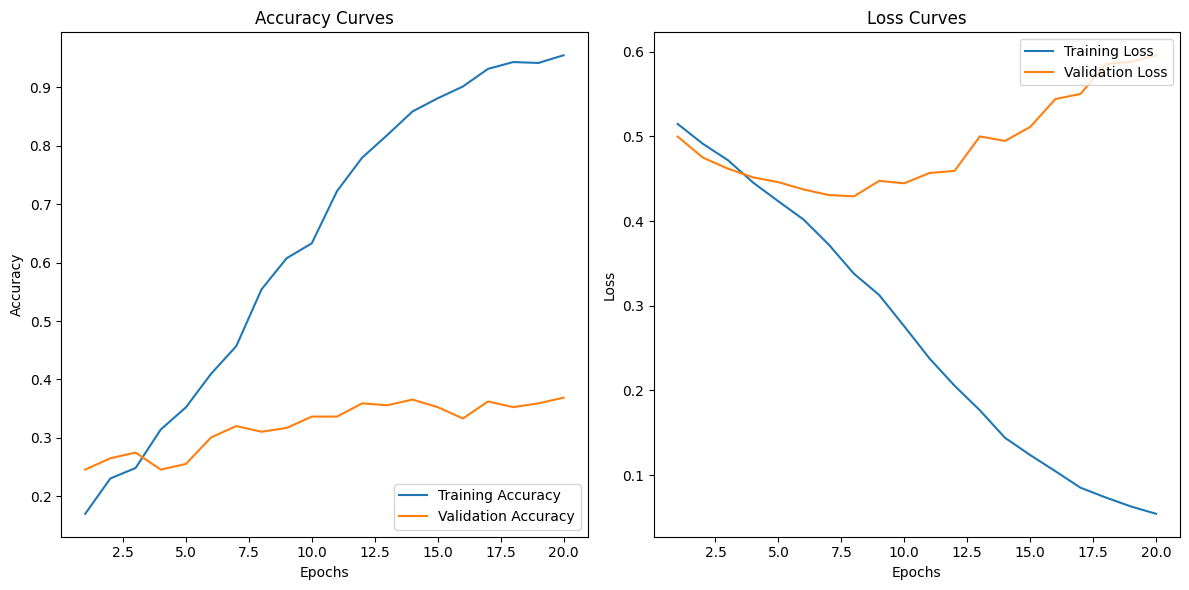

In [27]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import json
import uuid



model=BertClassifier(num_classes=8)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

best_val_acc = 0
best_epoch = 0
best_model_state = None

model_id = "TEST"

model.to(device)
for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

            output_1=model(input_id,mask)

            batch_loss_1=criterion(output_1,train_label.long())
            total_loss_train +=batch_loss_1.item()

            acc=(output_1.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss_1.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0

        y_true = []
        y_pred = []
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output_2= model(input_id,mask)

                # for scoring
                predicted = output_2.argmax(dim=1)
                y_true.extend(val_label.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

                batch_loss_2=criterion(output_2,val_label.long())

                total_loss_val+=batch_loss_2.item()

                acc=(output_2.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
            train_acc = total_acc_train / len(train_data)

        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        if val_acc > best_val_acc:
          best_epoch = epoch_num
          y_true_best = y_true.copy()
          y_pred_best = y_pred.copy()
          best_val_acc = val_acc
          best_model_state = model.state_dict()

        if epoch_num == epochs-1:
            print(f'______{model_id}______')
            print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
            print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
            print('____________')


# Plot the accuracy and loss curves over epochs
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss Curves')

plt.tight_layout()
plt.show()



# # Create a dictionary to store the results, hyperparameters, and model ID
# results_dict = {
#     'model_id': model_id,
#     'train_accuracy': train_acc_list,
#     'train_loss': train_loss_list,
#     'val_accuracy': val_acc_list,
#     'val_loss': val_loss_list,
#     'hyperparameters': {
#         'learning_rate': lr,
#         'num_epochs': epochs,
#         'batch_size': batch_size,
#         'max_len': max_len
#     },
#     'results': {
#         "last_acc": val_acc_list[-1],
#         'best_acc': best_val_acc,
#         'confusion_matrix': cm.tolist(),
#         'classification_report': report
#     }
# }

# # Save the results dictionary as a JSON file with the model ID
# results_filename = f'results_{model_id}.json'
# with open(results_filename, 'w') as f:
#     json.dump(results_dict, f, indent=4)

# # Save the best model state with the model ID
# model_filename = f'best_model_{model_id}.pth'
# torch.save(best_model_state, model_filename)

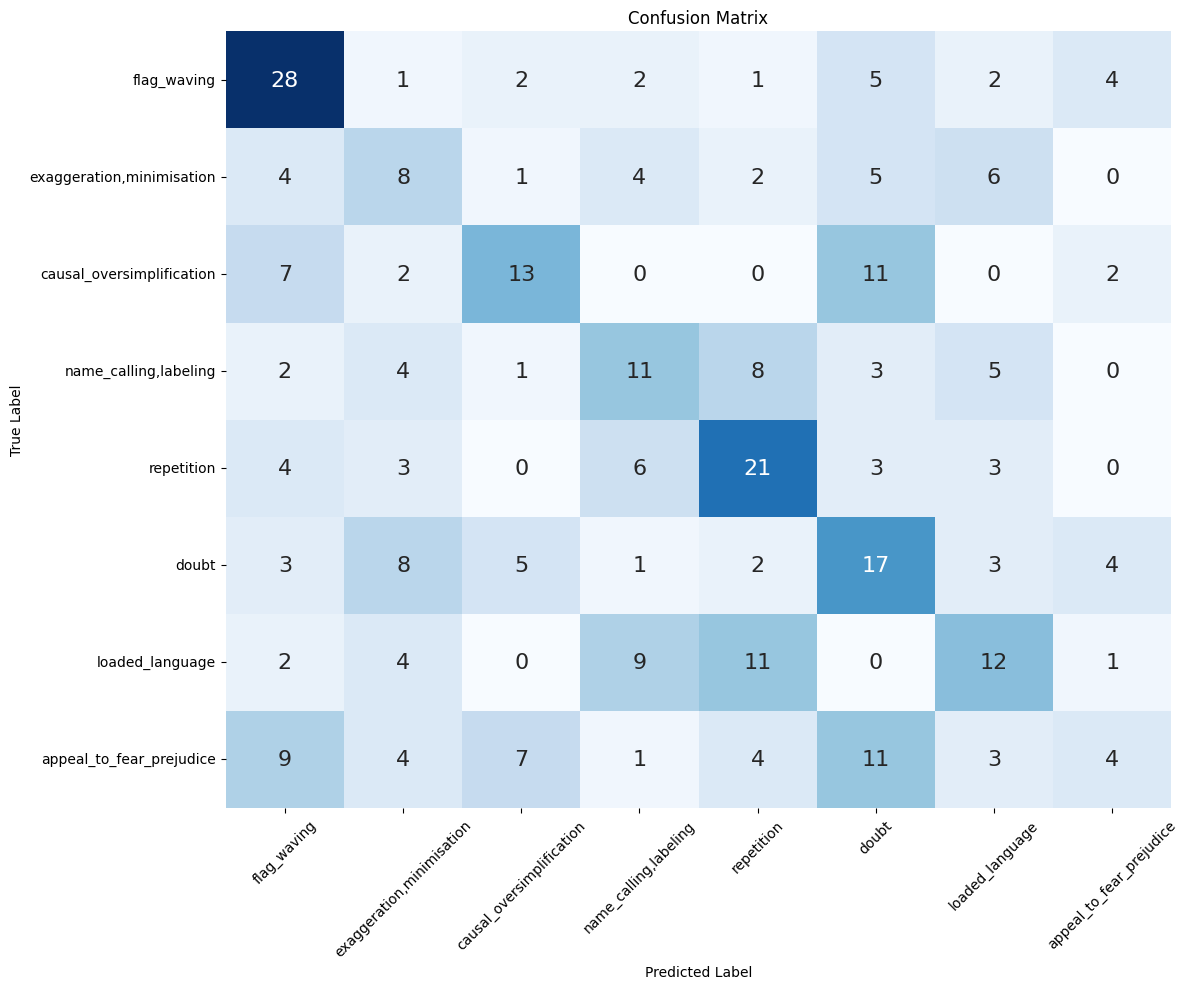

Classification Report:
                           precision    recall  f1-score   support

              flag_waving       0.47      0.62      0.54        45
exaggeration,minimisation       0.24      0.27      0.25        30
causal_oversimplification       0.45      0.37      0.41        35
    name_calling,labeling       0.32      0.32      0.32        34
               repetition       0.43      0.53      0.47        40
                    doubt       0.31      0.40      0.35        43
          loaded_language       0.35      0.31      0.33        39
 appeal_to_fear_prejudice       0.27      0.09      0.14        43

                 accuracy                           0.37       309
                macro avg       0.35      0.36      0.35       309
             weighted avg       0.36      0.37      0.35       309



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# analysis of best performing model
cm = confusion_matrix(y_true_best, y_pred_best)

# Create a DataFrame from the confusion matrix
classes = list(id_to_label.values())
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Compute precision, recall, F1-score, and other metrics for the best model
report = classification_report(y_true_best, y_pred_best, target_names=classes)
print('Classification Report:')
print(report)